# HW 3 - 205963168, 205671266

# Machine specifications

Personal Computer:

* CPU: Intel core i5 12400f
* RAM: 16 GB ddr4 3600 MHz
* GPU: NVIDIA GeForce RTX 3060 Ti

# Credits

Our work is based off of **"Learning Disentangled Joint Continuous and Discrete Representations"**.</br>
We decided to use the model, **JointVAE**, which seemed to fit our assignment.

# Our assignment

Disentangled representations are defined as ones where a change in a single unit of the representation
corresponds to a change in single factor of variation of the data while being invariant to others.

However, a large number of datasets contain inherently discrete generative factors which can be difficult to capture with these methods. In our dataset, distinct objects or entities would most naturally be represented by discrete
variables, while their position or scale might be represented by continuous variables.

Some examples of discrete features found in CelebA are:
* Eyeglasses
* Bangs
* Face position (forward, left side, right side)
* Age
* Oval face
* Face color
* Face expression (smile, neutral, frown)


In contrast to many supervised methods, the above paper focused on learning the latent representation of discrete features, in an unsupervised manner. 

The framework they proposed is based on Variational Autoencoders (VAE), and therfore comes with the advatages of VAE which includes: stable training, large sample diversity and a principled inference network; while having the flexibility to model a combination of continuous and discrete generative factors
 

## Loss function

### Modeling disentangled representations

Equation 1: $ \mathcal{L} (θ, φ) = \mathbb{E}_{q_φ(\mathbb{z}|\mathbb{x})}[\log{p_θ}(x|z)]  - \gamma | \mathcal{D}_{KL}q_φ(\mathbb{z}|\mathbb{x}) || p(z) - C|$  

In the loss function mentioned, we included two parameters beyond the usual ones found in the VAE loss function:
* controlled information capacity: $C$, is gradually increased during training
* regularization: $\gamma$, inspired by $\beta$ - VAE, which models a joint distribution of the data x and a set of latent variables z and learn continuous disentangled representations.  This constant also forces the KL divergence term to match the capacity C
  We started with $\gamma$ = 30 and when optimizing changed it to $\gamma$ = 100, as shown in the article. 


Gradually increasing C during training allows for control of the amount of information the model can encode. This objective has been shown to improve reconstruction quality as compared to a basic VAE loss function

### Modeling joint distribution of continuous and discrete latent variables

Equation 2: $ \mathcal{L} (θ, φ) = \mathbb{E}_{q_φ(\mathbb{z,c})|\mathbb{x})}[\log{p_θ}(\mathbb{x}|\mathbb{z,c})]  - \gamma | \mathcal{D}_{KL}q_φ(\mathbb{z}|\mathbb{x}) || p(z) - C_z|  - \gamma | \mathcal{D}_{KL}q_φ(\mathbb{c}|\mathbb{x}) || p(z) - C_c|$  


In equation 2, the capacities of the discrete and continuous latent channels are controlled
separately forcing the model to encode information both in the discrete and continuous channels.

## Parametrization of discrete latent variables

As expected, the toughest challenge was to model the discrete latent variables, specifically modeling $q_φ(\mathbb{c}|\mathbb{x})$, because this function has to be differentiable. Usually, categorical features are encoded using one-hot encoding.

In class, we learned about the ***Gumbel Max trick***, which gives us a continuous approximation $y$ for the one-hot representation of $c$.

Some definitions:
* $g_k \sim Gumbel(0,1)$ := $τ$ is the tempreture which controls the relaxation
* $\alpha_1, ... , \alpha_n$ := class probibilities of a categorical variable $c$

Therefore, our approximation is done via the following transformation:
$ y_k = \frac{\exp((\log \alpha_k + g_k)/τ)}{\sum_i\exp((\log \alpha_i + g_k)/τ)}$

The paper demonstrated that they are capable of modeling:
$q_φ(\mathbb{c}|\mathbb{x}) = ∏_i q_φ(\mathbb{c}|\mathbb{x}) $  as a function of $y$ and corresponding α's.

## Model Selection:

The following models were developed based on the original paper.

### Model 1: **No capacity**, 10 latent discrete features
We chose to experiment by disregarding the capacities outlined in equation 2, believing it would make little difference whether we ran JointVAE with or without these capacities. However, we found that the capacities are crucial for enabling the model to separate the latent spaces effectively.

In the next section, we will show the results of a model trained with capacity = 0, i.e equal to no capacity. 

In the reconstructed images, we will see that the reconstruction resulted in the same woman's face, with different backgrounds and face rotation. Then we will also show the loss plots, and we understand that the reason the reconstruction resulted in the same woman face is because the reconstruction and KL loss are unbalanced.

We discovered a mathematical solution to the mentioned problem called **KL cost annealing**, which serves a similar purpose to the capacity term. 

In our experiments, we set $\gamma = 30$.

### Model 2: 10 Latent Discrete Features
In this model, we included capacity regularization while keeping everything else the same. Surprisingly, this led to significantly better results.

For the experiments, we set $\gamma = 100$.

### Model 3: 40 Latent Discrete Features
In this optimization phase, we aimed to test whether our model could handle a discrete latent space with more than 10 dimensions. We selected 40 dimensions to match the dimensionality of the labels.

In these experiments, we also set $\gamma = 100$.

Each training framework required more than 15 hours to complete (on the aforementioned machine), which limited our ability to optimize further.

## Experiments

### Model params:
* batch size - 64
* discrete dimension - [10, 40]
* continues dimension - 32
* learning rate - 0.004
* optimizer - Adam 
* n_epochs - 100
* $\gamma$ - [30, 100]
* img size - (64,64)



### Model architecture

#### encoder layers:
  * Conv2d- output size: 32, filter: (4, 4), stride: 2, padding: 1
  * ReLU 
  * Conv2d- output size: 32, filter: (4, 4), stride: 2, padding: 1
  * ReLU
  * Conv2d- output size: 64, filter: (4, 4), stride: 2, padding: 1
  * ReLU
  * Conv2d- output size: 64, filter: (4, 4), stride: 2, padding: 1
  * ReLU

#### Decoder layers:
  * Conv2d- output size: 64, filter: (4, 4), stride: 2, padding: 1
  * ReLU 
  * Conv2d- output size: 32, filter: (4, 4), stride: 2, padding: 1
  * ReLU
  * Conv2d- output size: 32, filter: (4, 4), stride: 2, padding: 1
  * ReLU
  * Conv2d- output size: 64*64, filter: (4, 4), stride: 2, padding: 1
  * ReLU

#### fully connected alphas:
 * Linear:  input size: 256, output size: discrete dim

####  mu and var layers:
  * Linear:  input size: 256, output size: continuous dim
  * Linear:  input size: 256, output size: continuous dim

#### Bottleneck (latent dims to features) 
  * Linear: input:  continuous + discrete dim , output: 256
  * ReLU
  * Linear: input:  256, output: 64 * 4 * 4
  * ReLU

#### output layers:
  * Linear - input size: 64 * 4 * 4, output size: 256
  * ReLU


#### Necessary imports

In [1]:
import matplotlib as plt
import pandas as pd 
import numpy as np
from model import VAE
import os
import matplotlib.pyplot as plt
from PIL import Image
import os
import torch

# Model 1 - No capacity

## Loss graphs

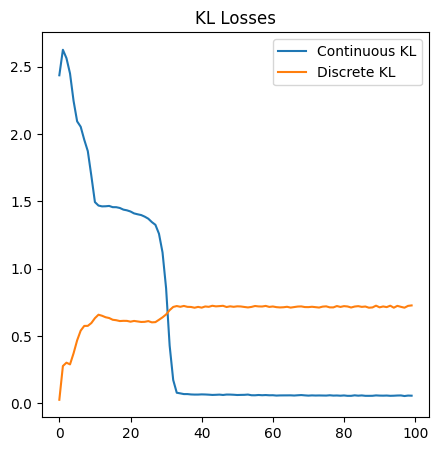

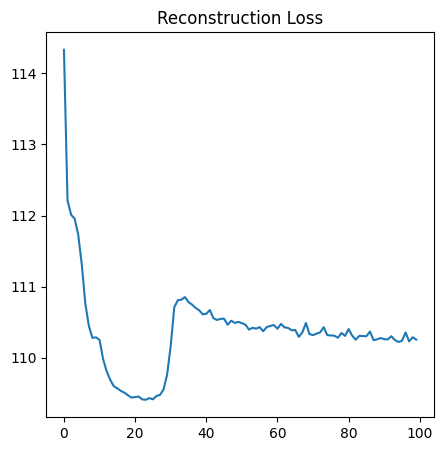

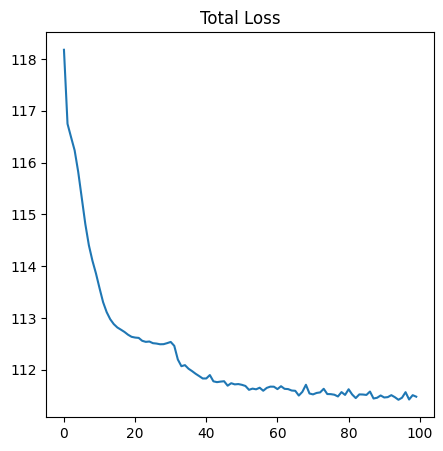

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the model name
model_name = 'model_1'

# Construct the file path
file_path = f'./outputs/outputs_{model_name}/loss_{model_name}.csv'
loss_data = pd.read_csv(file_path)

# Extract loss components
recon_loss = loss_data['recon_loss'].values
kl_loss_disc = loss_data['kl_loss_disc'].values
kl_loss_cont = loss_data['kl_loss_cont'].values
total_loss = loss_data['loss'].values

# Plot continuous and discrete KL loss
plt.figure(figsize=(5, 5))
plt.plot(range(len(kl_loss_cont)), kl_loss_cont, label='Continuous KL')
plt.plot(range(len(kl_loss_disc)), kl_loss_disc, label='Discrete KL')
plt.title('KL Losses')
plt.legend()
plt.show()

# Plot reconstruction loss
plt.figure(figsize=(5, 5))
plt.plot(range(len(recon_loss)), recon_loss)
plt.title('Reconstruction Loss')
plt.show()

# Plot total loss
plt.figure(figsize=(5, 5))
plt.plot(range(len(total_loss)), total_loss)
plt.title('Total Loss')
plt.show()


### Observations:
* With the KL loss being approximately 10^4 times smaller than the reconstruction loss, its influence on the learning process is understandably minimal.
* After around 40 epochs, the KL loss decreases to zero, indicating difficulties in image reconstruction by the model.
* Optimal total loss is achieved around 50 epochs, suggesting that early stopping could have been beneficial.

## Reconstruction

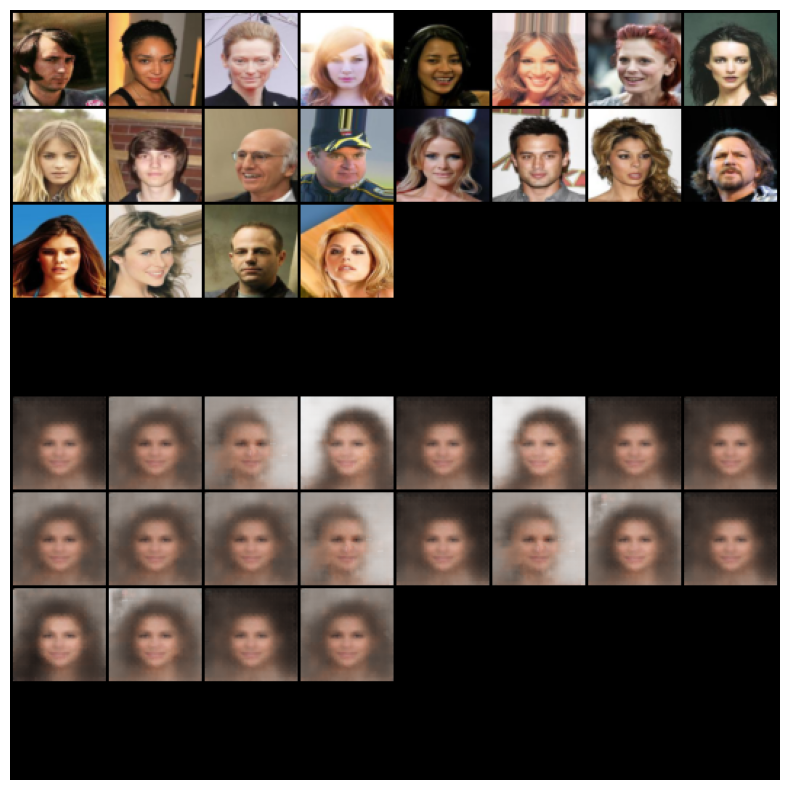

In [3]:
img = Image.open('./outputs/outputs_model_1/recon.png')
fig, axs = plt.subplots(nrows= 1, ncols=1, figsize= (10,10))
plt.axis('off')
axs.imshow(img)

## Drawing Samples from the Latent Space (Prior) and Displaying the Outcomes

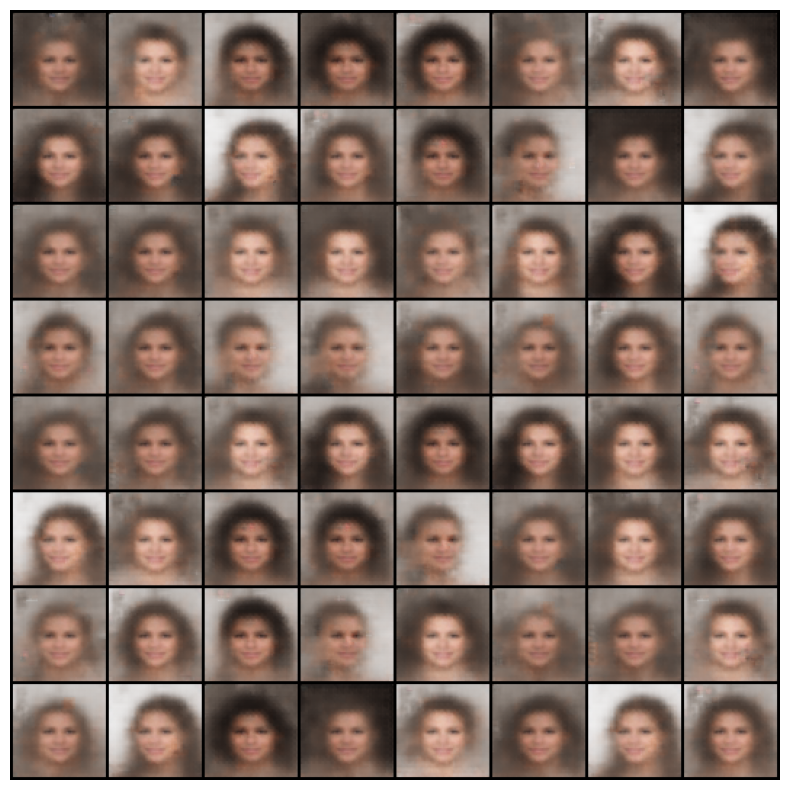

In [4]:
img = Image.open('outputs/outputs_model_1/samples.png')
fig, axs = plt.subplots(nrows= 1, ncols=1, figsize= (10,10))
plt.axis('off')
axs.imshow(img)

## Summary:

* Based on our understanding from the class, training a VAE primarily on reconstruction, as done in this instance, limits disentanglement. Consequently, this causes the classes—or in this case, faces—to appear very similar, leading to a clustering effect in the latent vectors.
* Sampling from the latent space further demonstrates this issue, as it repeatedly produces images of the same woman, albeit with variations in background, hair, and face orientation, while her facial expression remains unchanged.

Overall, it's evident that our model's learning capability was suboptimal.

# Model 2 - Capacity with discrete dim =10

## Loss graphs

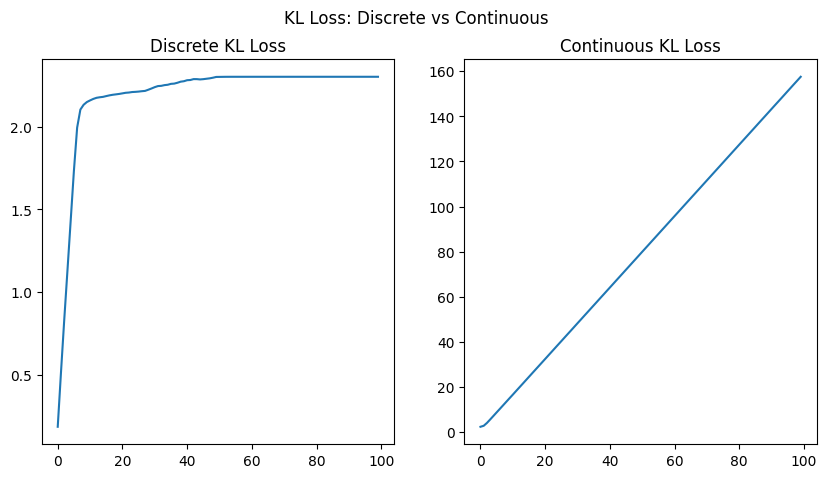

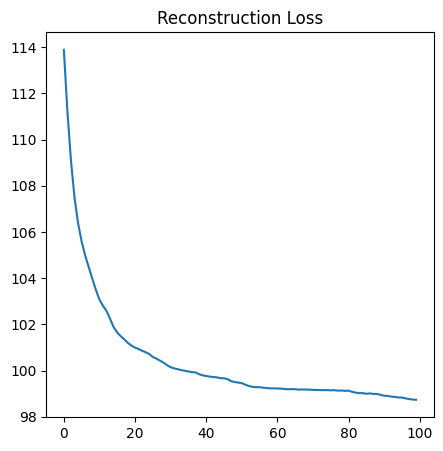

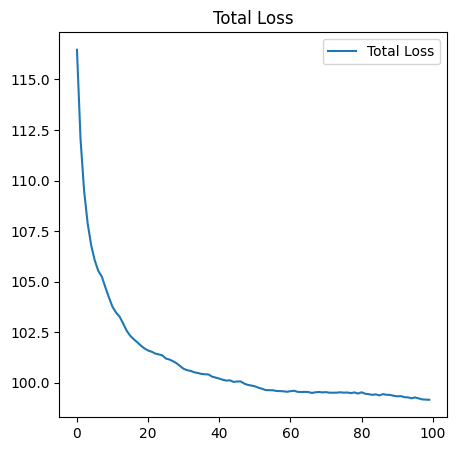

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Set the model name
model = 'model_2'

# Construct the path for the CSV file
path = f'outputs/outputs_{model}/loss_{model}.csv'
model_loss = pd.read_csv(path)

# Extract KL losses for discrete and continuous variables
kl_loss_disc = model_loss['kl_loss_disc'].values
kl_loss_cont = model_loss['kl_loss_cont'].values

# Plot the discrete and continuous KL losses
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
plt.suptitle('KL Loss: Discrete vs Continuous')

axes[0].plot(range(len(kl_loss_disc)), kl_loss_disc)
axes[0].set_title('Discrete KL Loss')

axes[1].plot(range(len(kl_loss_cont)), kl_loss_cont)
axes[1].set_title('Continuous KL Loss')
plt.show()

# Extract and plot reconstruction loss
recon_loss = model_loss['recon_loss'].values
plt.figure(figsize=(5, 5))
plt.plot(range(len(recon_loss)), recon_loss)
plt.title('Reconstruction Loss')
plt.show()

# Extract and plot total loss
total_loss = model_loss['loss'].values
plt.figure(figsize=(5, 5))
plt.plot(range(len(total_loss)), total_loss)
plt.title('Total Loss')
plt.legend(['Total Loss'])
plt.show()


## Reconstruction

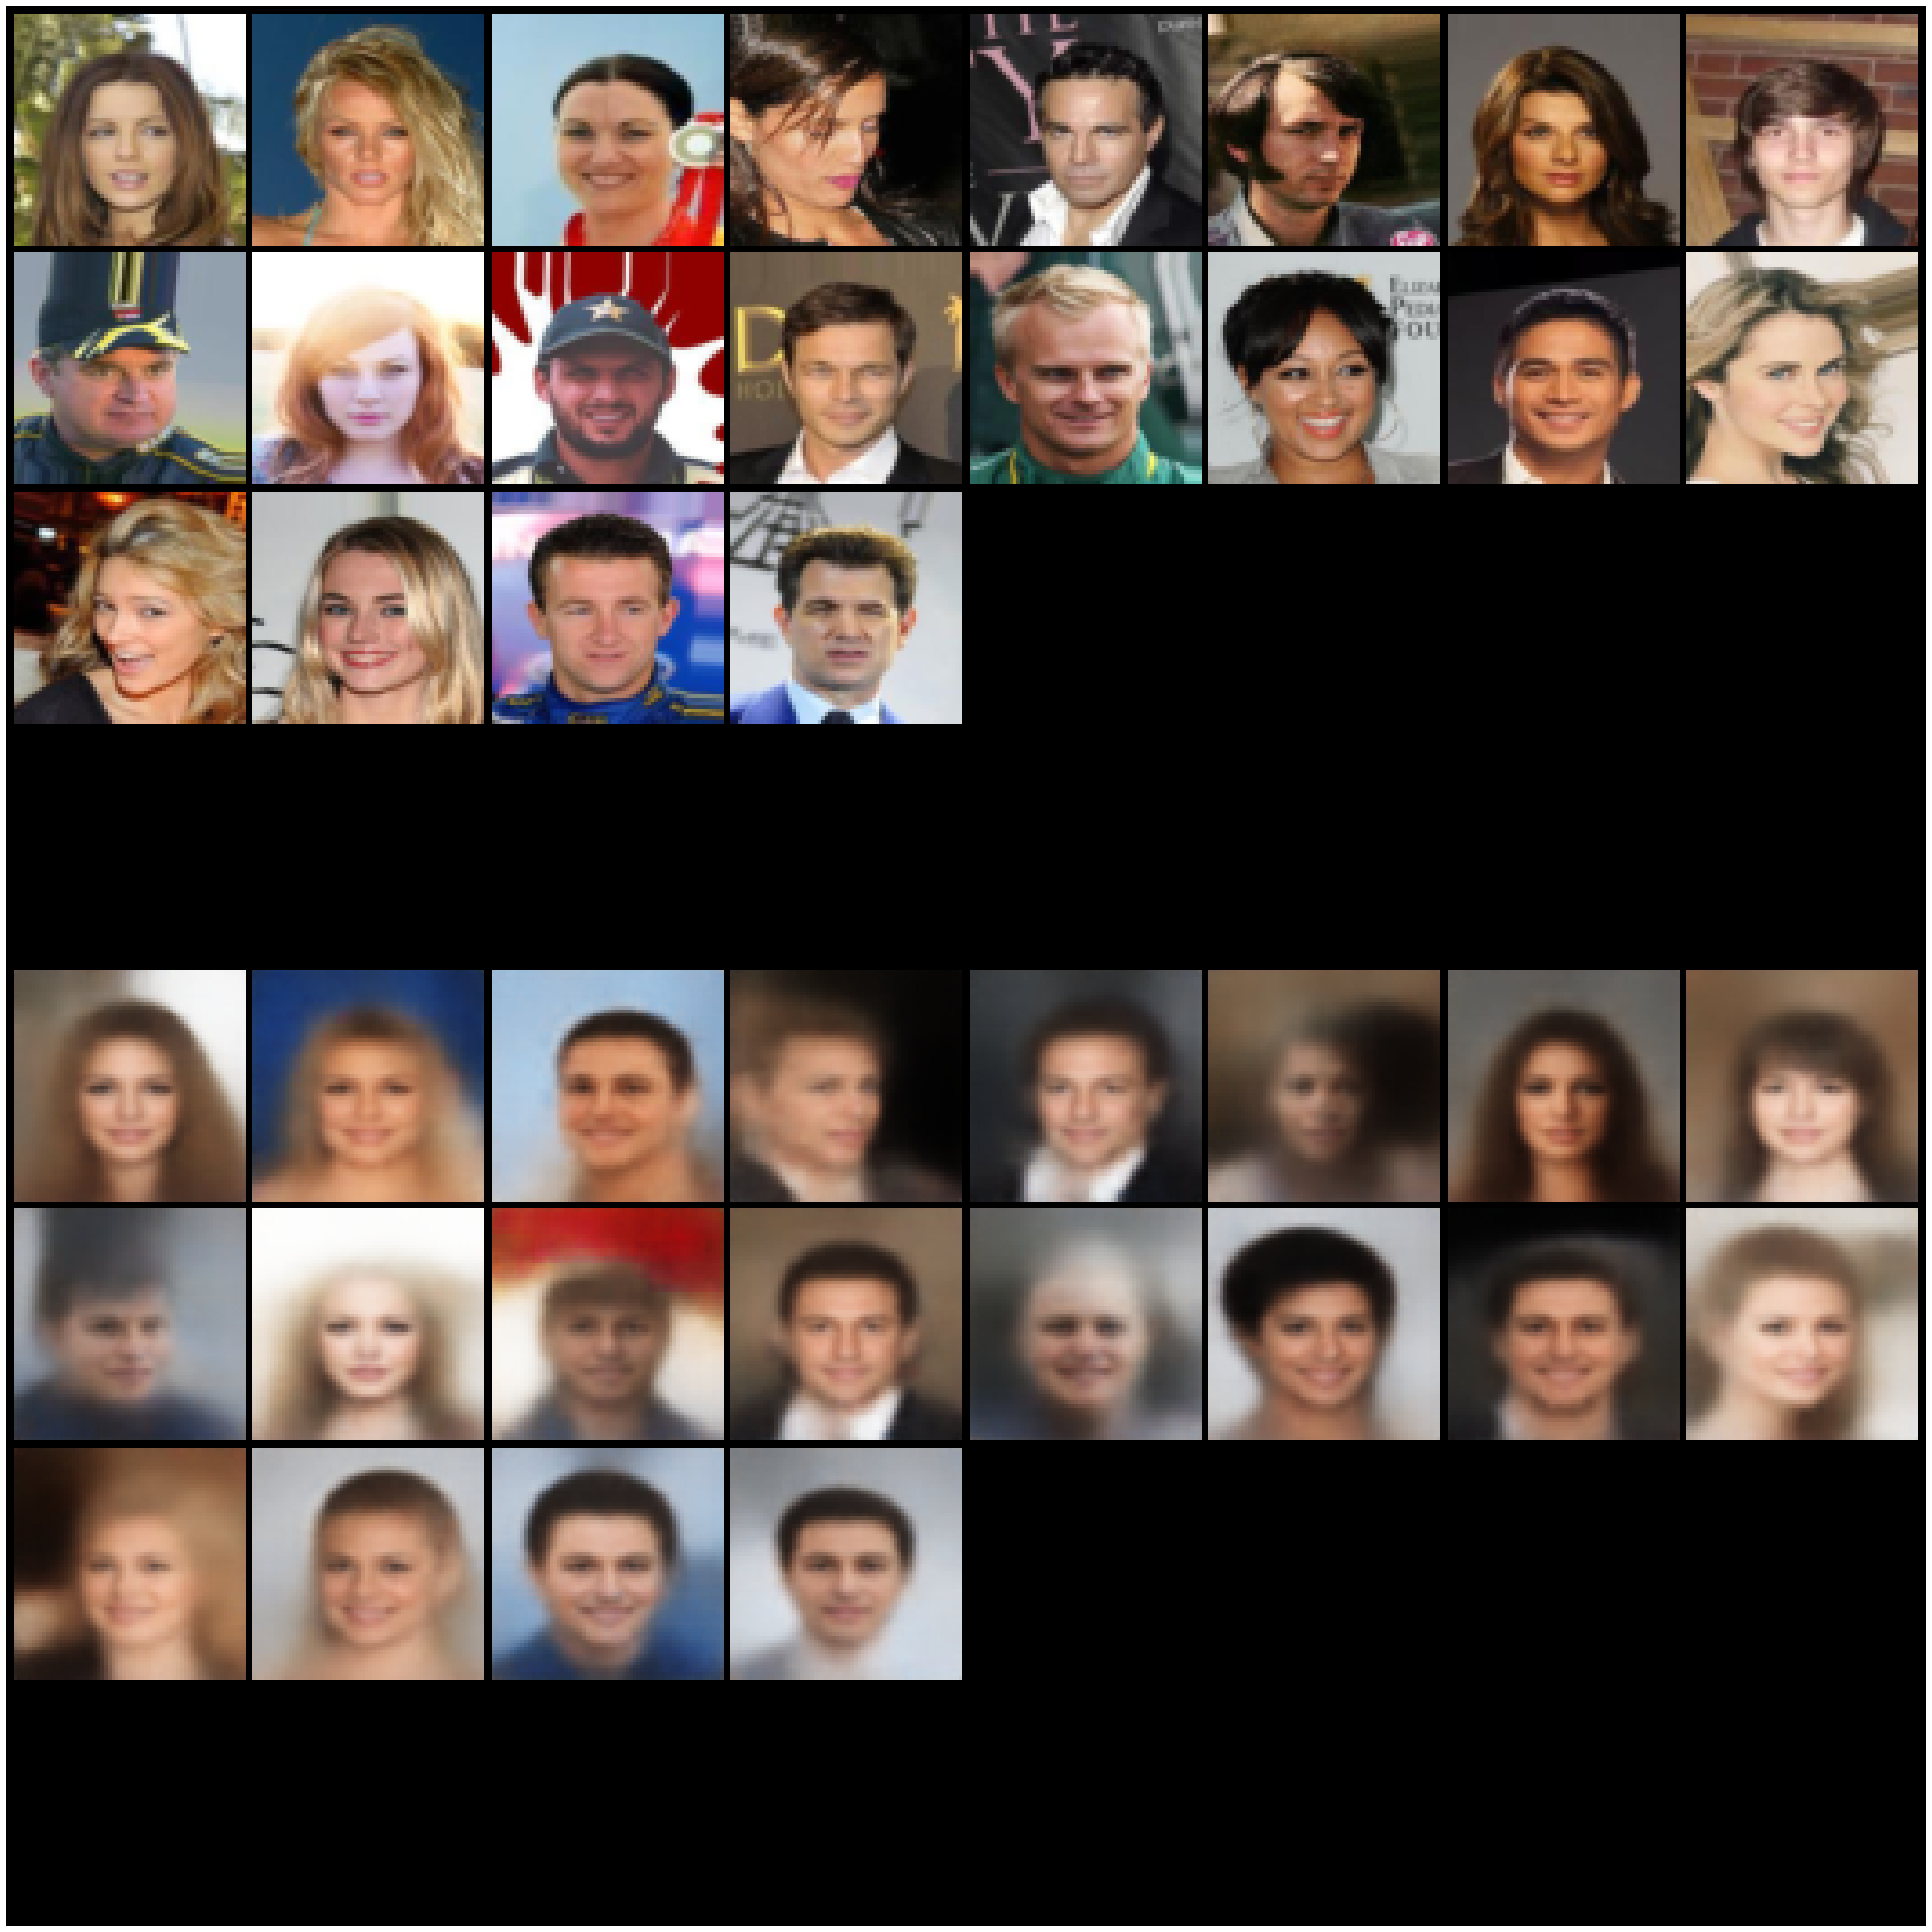

In [6]:
img = Image.open(f'outputs/outputs_{model}/recon.png')
fig, axs = plt.subplots(nrows= 1, ncols=1, figsize= (40,40))
plt.axis('off')
axs.imshow(img)

# Model 3 - Capacity &  discrete dim = 40

## Loss graphs

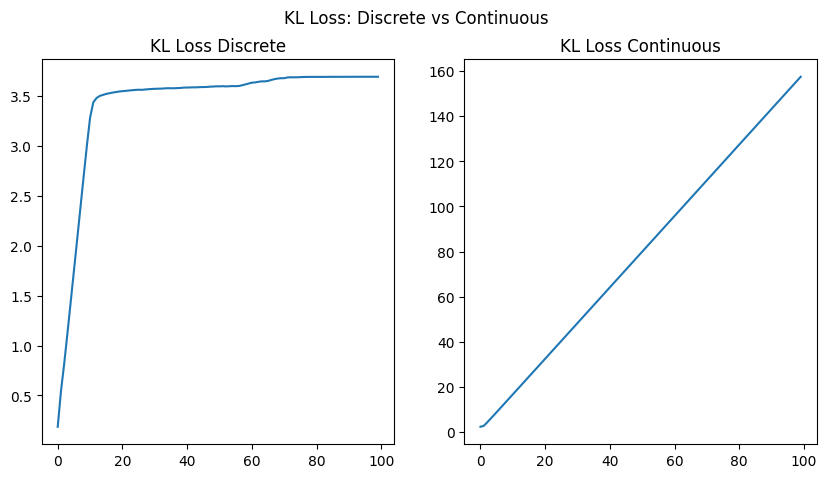

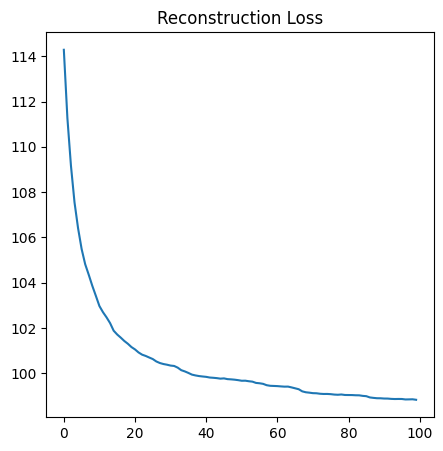

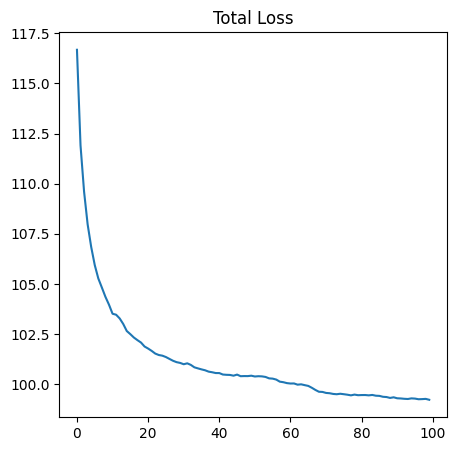

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the model identifier
model = 'model_3'

# Construct the file path for the loss data
path = f'outputs/outputs_{model}/loss_{model}.csv'
loss_data = pd.read_csv(path)

# Extract different types of losses
kl_loss_disc = loss_data['kl_loss_disc'].values
kl_loss_cont = loss_data['kl_loss_cont'].values
recon_loss = loss_data['recon_loss'].values
total_loss = loss_data['loss'].values

# Plot KL discrete and continuous losses
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
plt.suptitle('KL Loss: Discrete vs Continuous')

axes[0].plot(range(len(kl_loss_disc)), kl_loss_disc)
axes[0].set_title('KL Loss Discrete')

axes[1].plot(range(len(kl_loss_cont)), kl_loss_cont)
axes[1].set_title('KL Loss Continuous')
plt.show()

# Plot reconstruction loss
plt.figure(figsize=(5, 5))
plt.plot(range(len(recon_loss)), recon_loss)
plt.title('Reconstruction Loss')
plt.show()

# Plot total loss
plt.figure(figsize=(5, 5))
plt.plot(range(len(total_loss)), total_loss)
plt.title('Total Loss')
plt.show()


## Summary:

* It is observed, as expected, that both the continuous and discrete KL losses escalate with the progression of epochs.
* The KL term's increment, linearly proportional to the epochs, results in a linear uptick in the continuous loss, whereas the discrete loss exhibits a logarithmic rise.
    - A noteworthy point is that the upper bound used for computing the capacity of the discrete KL loss term is, indeed, logarithmic in nature.

## Reconstruction

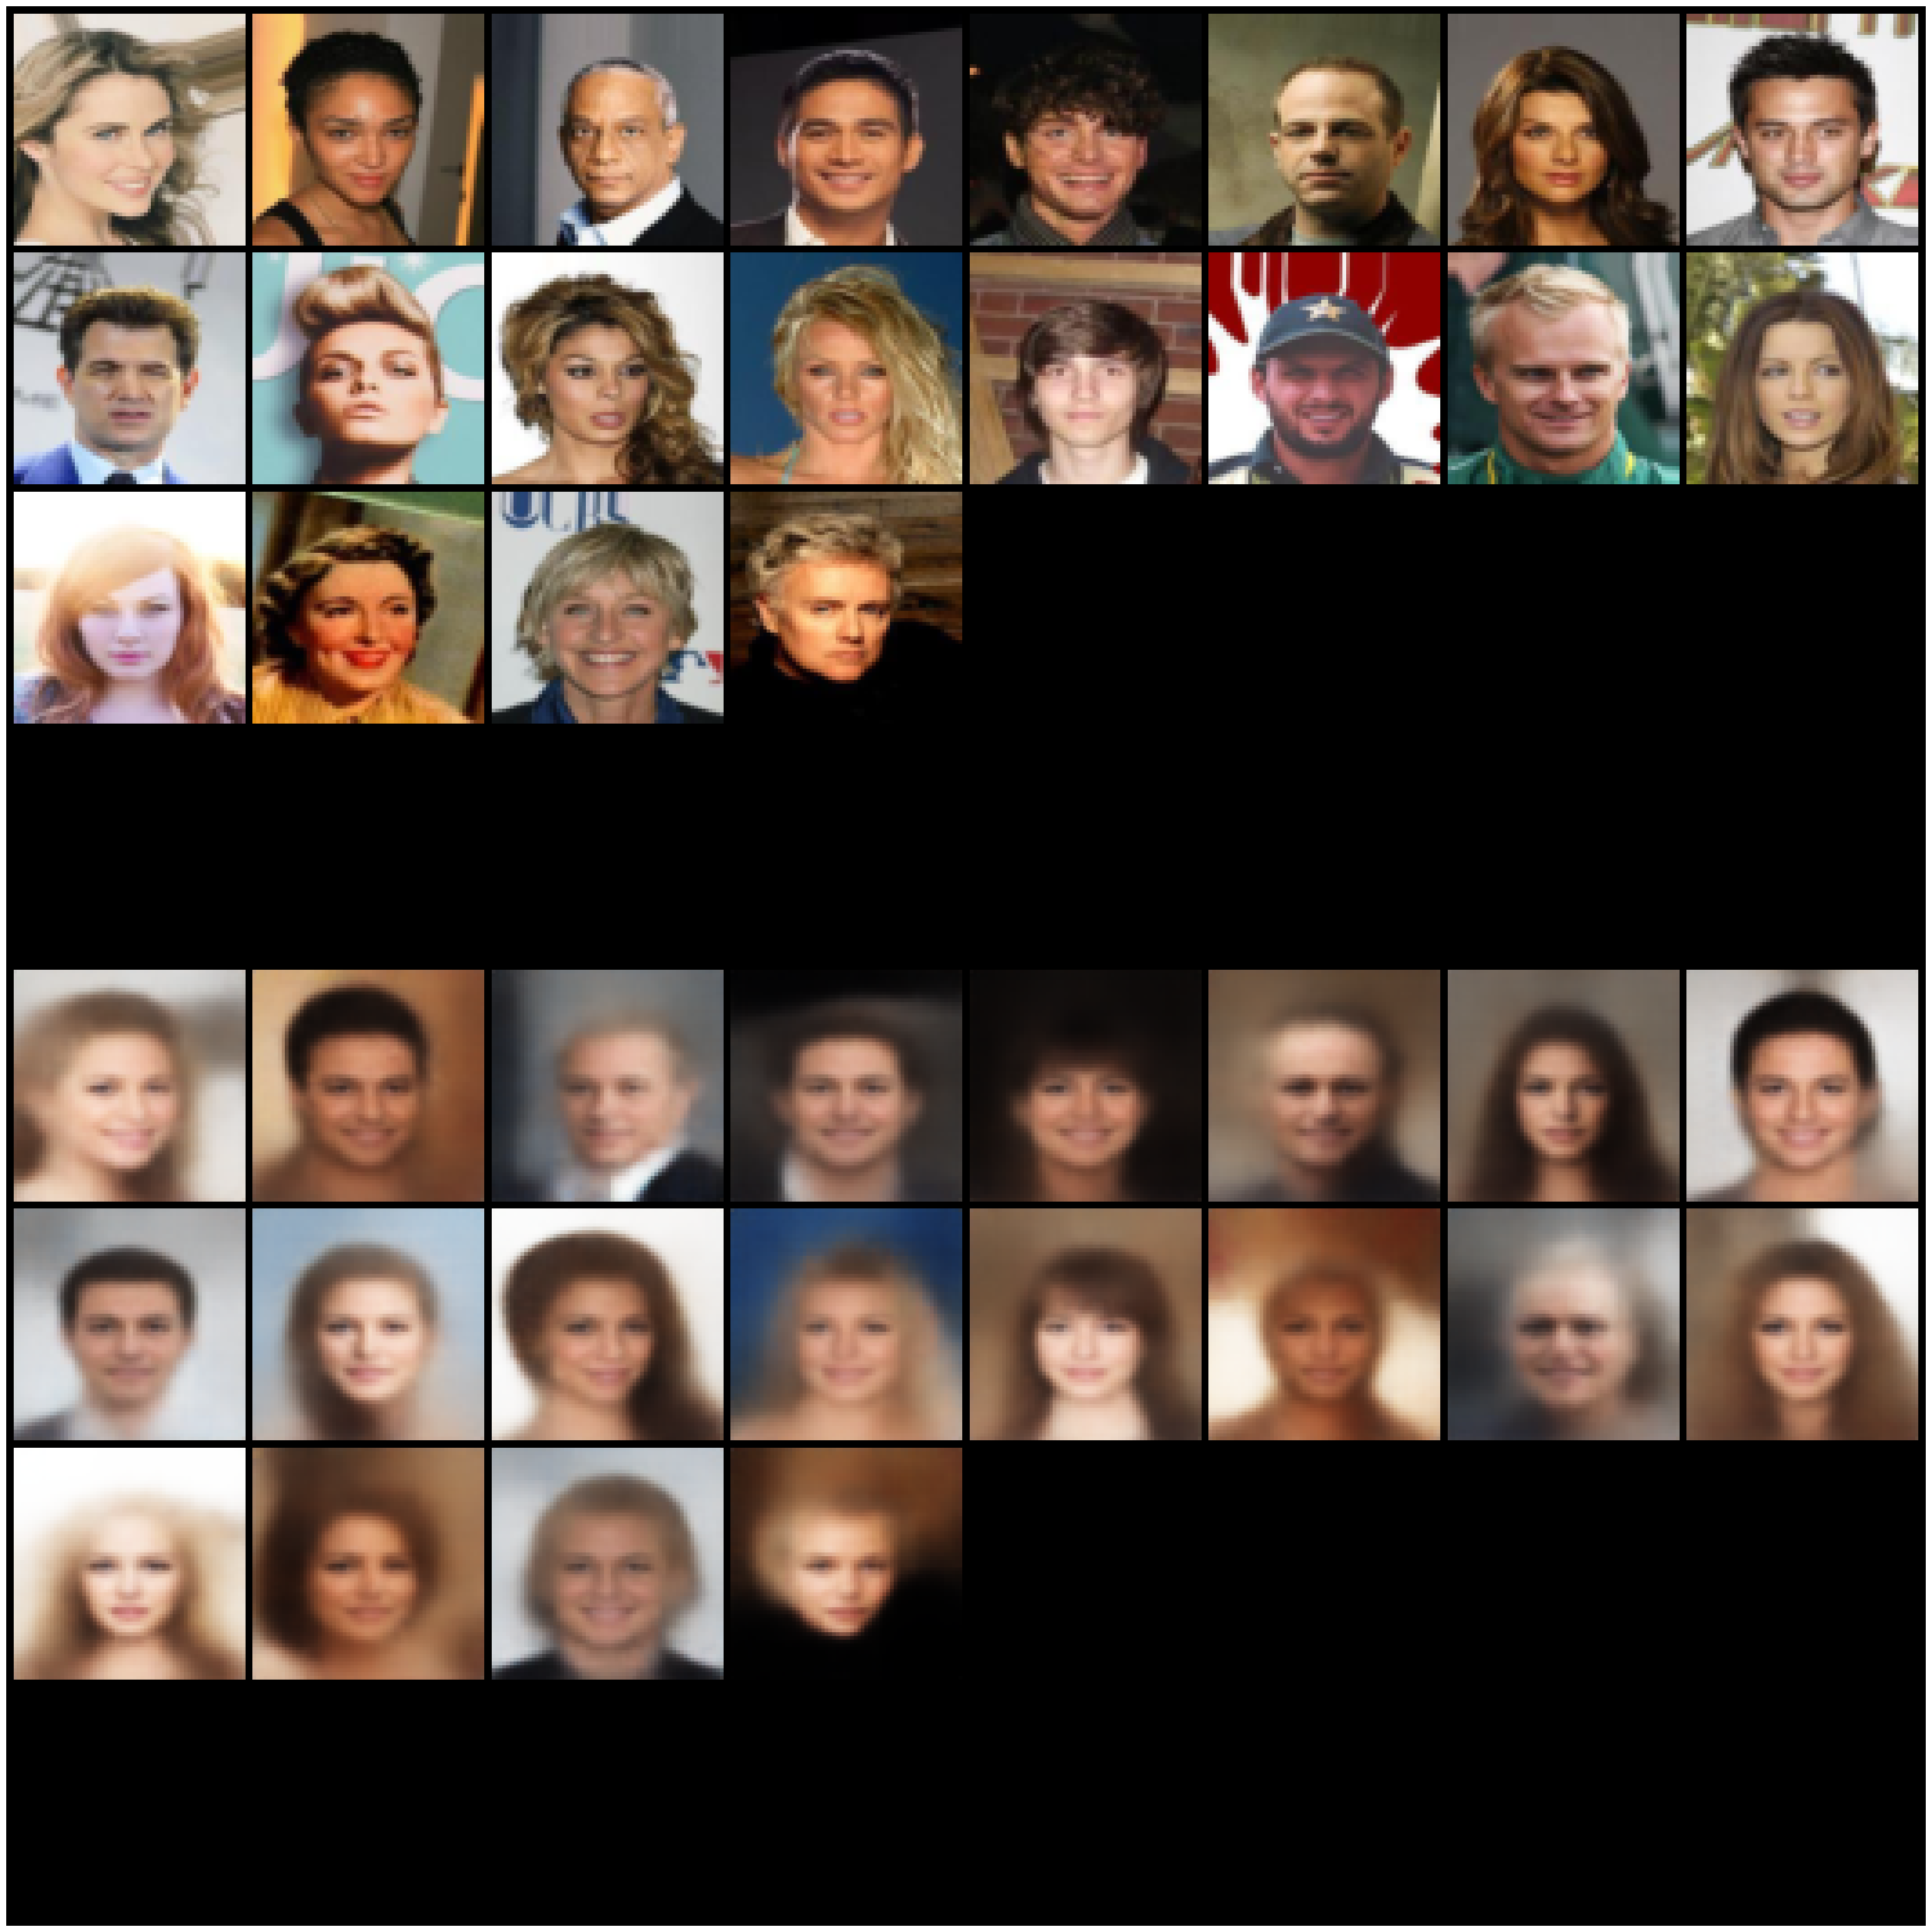

In [8]:
img = Image.open(f'outputs/outputs_{model}/recon.png')
fig, axs = plt.subplots(nrows= 1, ncols=1, figsize= (40,40))
plt.axis('off')
axs.imshow(img)

## Conclusions: 

Our latest model, enhanced with capacity and a discrete dimension of 40, shows significant improvement in image reconstruction compared to the initial one.</br>
It exhibits a richer palette of colors, a wider range of angles, and greater variety in skin tones, hair lengths, attire, and backgrounds. However, it's important to acknowledge that the images remain somewhat blurry, illustrating the principle that there are no free lunches. In other words, while we succeeded in creating a latent space encompassing both discrete and continuous variables, it came at the cost of less than perfect reconstruction quality.